In [1]:
'''
Description :
Develop an AI model capable of detecting fraudulent transactions in real-time. Use historical transaction data to train the model 
to identify anomalies and flag suspicious activities.

Objective :
Successfully implement and deploy a model that can accurately detect fraudulent transactions with minimal false positives.
'''
# Importing all required libraries for data processing, model training, evaluation, and visualization
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the fraud dataset for training the model
df = pd.read_csv("fraud_dataset.csv")

In [3]:
df.head()

,transaction_id,timestamp,amount,merchant_category,customer_id,customer_age,customer_location,device_type,previous_transactions,is_fraud
0,916306a3-f7e2-4371-992a-38ab8030b680,1/2/2022 6:53,46.93,fuel,bef45806-a255-4cdb-a45e-012d533eee34,48,NY,tablet,2,0
1,2d922a41-edd9-4649-81f0-c599db4b923d,9/5/2024 14:18,301.01,electronics,f600bad0-d244-42c4-9db3-1115214dd1c4,58,IL,mobile,4,0
2,9d2ec6cd-f8ed-4c68-9ec7-1450c30b7fe0,12/7/2022 6:24,131.67,entertainment,050c0996-fd20-4ce0-94ec-b1bbc1f3c229,23,TX,tablet,2,0
3,f65f1e63-1b91-4a79-95e4-4dd825992461,8/19/2022 3:58,91.29,fashion,71693a5a-7103-4876-9e03-0fcb64ba3e28,69,FL,desktop,6,0
4,e6a8161d-4fdc-4483-9b61-2c8c86567e78,4/19/2023 12:55,16.96,fashion,18ed5ca8-d0eb-4ccf-b4d3-fa37f15b89c7,48,TX,tablet,0,0


In [4]:
# Converting timestamp to datetime and extracting useful time-based features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [5]:
df.head()

,transaction_id,timestamp,amount,merchant_category,customer_id,customer_age,customer_location,device_type,previous_transactions,is_fraud,hour,day,month,weekday,is_weekend
0,916306a3-f7e2-4371-992a-38ab8030b680,2022-01-02 06:53:00,46.93,fuel,bef45806-a255-4cdb-a45e-012d533eee34,48,NY,tablet,2,0,6,2,1,6,1
1,2d922a41-edd9-4649-81f0-c599db4b923d,2024-09-05 14:18:00,301.01,electronics,f600bad0-d244-42c4-9db3-1115214dd1c4,58,IL,mobile,4,0,14,5,9,3,0
2,9d2ec6cd-f8ed-4c68-9ec7-1450c30b7fe0,2022-12-07 06:24:00,131.67,entertainment,050c0996-fd20-4ce0-94ec-b1bbc1f3c229,23,TX,tablet,2,0,6,7,12,2,0
3,f65f1e63-1b91-4a79-95e4-4dd825992461,2022-08-19 03:58:00,91.29,fashion,71693a5a-7103-4876-9e03-0fcb64ba3e28,69,FL,desktop,6,0,3,19,8,4,0
4,e6a8161d-4fdc-4483-9b61-2c8c86567e78,2023-04-19 12:55:00,16.96,fashion,18ed5ca8-d0eb-4ccf-b4d3-fa37f15b89c7,48,TX,tablet,0,0,12,19,4,2,0


In [6]:
# Adding customer-level statistics (avg_amount, std_amount, txn_count)
customer_stats = df.groupby('customer_id')['amount'].agg(['mean', 'std', 'count']).reset_index()
customer_stats.rename(columns={'mean': 'avg_amount', 'std': 'std_amount', 'count': 'txn_count'}, inplace=True)
df = df.merge(customer_stats, on='customer_id', how='left')

In [7]:
df.head()

,transaction_id,timestamp,amount,merchant_category,customer_id,customer_age,customer_location,device_type,previous_transactions,is_fraud,hour,day,month,weekday,is_weekend,avg_amount,std_amount,txn_count
0,916306a3-f7e2-4371-992a-38ab8030b680,2022-01-02 06:53:00,46.93,fuel,bef45806-a255-4cdb-a45e-012d533eee34,48,NY,tablet,2,0,6,2,1,6,1,46.93,NaN,1
1,2d922a41-edd9-4649-81f0-c599db4b923d,2024-09-05 14:18:00,301.01,electronics,f600bad0-d244-42c4-9db3-1115214dd1c4,58,IL,mobile,4,0,14,5,9,3,0,301.01,NaN,1
2,9d2ec6cd-f8ed-4c68-9ec7-1450c30b7fe0,2022-12-07 06:24:00,131.67,entertainment,050c0996-fd20-4ce0-94ec-b1bbc1f3c229,23,TX,tablet,2,0,6,7,12,2,0,131.67,NaN,1
3,f65f1e63-1b91-4a79-95e4-4dd825992461,2022-08-19 03:58:00,91.29,fashion,71693a5a-7103-4876-9e03-0fcb64ba3e28,69,FL,desktop,6,0,3,19,8,4,0,91.29,NaN,1
4,e6a8161d-4fdc-4483-9b61-2c8c86567e78,2023-04-19 12:55:00,16.96,fashion,18ed5ca8-d0eb-4ccf-b4d3-fa37f15b89c7,48,TX,tablet,0,0,12,19,4,2,0,16.96,NaN,1


In [8]:
# Calculating merchant_fraud_rate based on historical fraud percentage
merchant_fraud = df.groupby('merchant_category')['is_fraud'].mean().to_dict()
df['merchant_fraud_rate'] = df['merchant_category'].map(merchant_fraud)

In [9]:
df.head()

,transaction_id,timestamp,amount,merchant_category,customer_id,customer_age,customer_location,device_type,previous_transactions,is_fraud,hour,day,month,weekday,is_weekend,avg_amount,std_amount,txn_count,merchant_fraud_rate
0,916306a3-f7e2-4371-992a-38ab8030b680,2022-01-02 06:53:00,46.93,fuel,bef45806-a255-4cdb-a45e-012d533eee34,48,NY,tablet,2,0,6,2,1,6,1,46.93,NaN,1,0.020927
1,2d922a41-edd9-4649-81f0-c599db4b923d,2024-09-05 14:18:00,301.01,electronics,f600bad0-d244-42c4-9db3-1115214dd1c4,58,IL,mobile,4,0,14,5,9,3,0,301.01,NaN,1,0.024904
2,9d2ec6cd-f8ed-4c68-9ec7-1450c30b7fe0,2022-12-07 06:24:00,131.67,entertainment,050c0996-fd20-4ce0-94ec-b1bbc1f3c229,23,TX,tablet,2,0,6,7,12,2,0,131.67,NaN,1,0.016486
3,f65f1e63-1b91-4a79-95e4-4dd825992461,2022-08-19 03:58:00,91.29,fashion,71693a5a-7103-4876-9e03-0fcb64ba3e28,69,FL,desktop,6,0,3,19,8,4,0,91.29,NaN,1,0.015979
4,e6a8161d-4fdc-4483-9b61-2c8c86567e78,2023-04-19 12:55:00,16.96,fashion,18ed5ca8-d0eb-4ccf-b4d3-fa37f15b89c7,48,TX,tablet,0,0,12,19,4,2,0,16.96,NaN,1,0.015979


In [10]:
# Creating derived features like txn_amount_ratio, is_high_amount, is_new_customer
df['txn_amount_ratio'] = df['amount'] / (df['avg_amount'] + 1e-5)
df['is_high_amount'] = (df['amount'] > 2 * df['avg_amount']).astype(int)
df['is_new_customer'] = (df['previous_transactions'] == 0).astype(int)

In [11]:
df.head()

,transaction_id,timestamp,amount,merchant_category,customer_id,customer_age,customer_location,device_type,previous_transactions,is_fraud,...,month,weekday,is_weekend,avg_amount,std_amount,txn_count,merchant_fraud_rate,txn_amount_ratio,is_high_amount,is_new_customer
0,916306a3-f7e2-4371-992a-38ab8030b680,2022-01-02 06:53:00,46.93,fuel,bef45806-a255-4cdb-a45e-012d533eee34,48,NY,tablet,2,0,...,1,6,1,46.93,NaN,1,0.020927,1.000000,0,0
1,2d922a41-edd9-4649-81f0-c599db4b923d,2024-09-05 14:18:00,301.01,electronics,f600bad0-d244-42c4-9db3-1115214dd1c4,58,IL,mobile,4,0,...,9,3,0,301.01,NaN,1,0.024904,1.000000,0,0
2,9d2ec6cd-f8ed-4c68-9ec7-1450c30b7fe0,2022-12-07 06:24:00,131.67,entertainment,050c0996-fd20-4ce0-94ec-b1bbc1f3c229,23,TX,tablet,2,0,...,12,2,0,131.67,NaN,1,0.016486,1.000000,0,0
3,f65f1e63-1b91-4a79-95e4-4dd825992461,2022-08-19 03:58:00,91.29,fashion,71693a5a-7103-4876-9e03-0fcb64ba3e28,69,FL,desktop,6,0,...,8,4,0,91.29,NaN,1,0.015979,1.000000,0,0
4,e6a8161d-4fdc-4483-9b61-2c8c86567e78,2023-04-19 12:55:00,16.96,fashion,18ed5ca8-d0eb-4ccf-b4d3-fa37f15b89c7,48,TX,tablet,0,0,...,4,2,0,16.96,NaN,1,0.015979,0.999999,0,1


In [12]:
# Dropping IDs
df = df.drop(['transaction_id', 'customer_id', 'timestamp'], axis=1)

In [13]:
df.head()

,amount,merchant_category,customer_age,customer_location,device_type,previous_transactions,is_fraud,hour,day,month,weekday,is_weekend,avg_amount,std_amount,txn_count,merchant_fraud_rate,txn_amount_ratio,is_high_amount,is_new_customer
0,46.93,fuel,48,NY,tablet,2,0,6,2,1,6,1,46.93,NaN,1,0.020927,1.000000,0,0
1,301.01,electronics,58,IL,mobile,4,0,14,5,9,3,0,301.01,NaN,1,0.024904,1.000000,0,0
2,131.67,entertainment,23,TX,tablet,2,0,6,7,12,2,0,131.67,NaN,1,0.016486,1.000000,0,0
3,91.29,fashion,69,FL,desktop,6,0,3,19,8,4,0,91.29,NaN,1,0.015979,1.000000,0,0
4,16.96,fashion,48,TX,tablet,0,0,12,19,4,2,0,16.96,NaN,1,0.015979,0.999999,0,1


In [14]:
# encoding categorical variables
encoders = {}
for col in ['merchant_category', 'customer_location', 'device_type']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


In [15]:
df.head()

,amount,merchant_category,customer_age,customer_location,device_type,previous_transactions,is_fraud,hour,day,month,weekday,is_weekend,avg_amount,std_amount,txn_count,merchant_fraud_rate,txn_amount_ratio,is_high_amount,is_new_customer
0,46.93,3,48,3,2,2,0,6,2,1,6,1,46.93,NaN,1,0.020927,1.000000,0,0
1,301.01,0,58,2,1,4,0,14,5,9,3,0,301.01,NaN,1,0.024904,1.000000,0,0
2,131.67,1,23,4,2,2,0,6,7,12,2,0,131.67,NaN,1,0.016486,1.000000,0,0
3,91.29,2,69,1,0,6,0,3,19,8,4,0,91.29,NaN,1,0.015979,1.000000,0,0
4,16.96,2,48,4,2,0,0,12,19,4,2,0,16.96,NaN,1,0.015979,0.999999,0,1


In [16]:
# Filling all missing (NaN) values with 0 to avoid errors during model training and prediction
df.fillna(0, inplace=True)

In [17]:
df.head()

,amount,merchant_category,customer_age,customer_location,device_type,previous_transactions,is_fraud,hour,day,month,weekday,is_weekend,avg_amount,std_amount,txn_count,merchant_fraud_rate,txn_amount_ratio,is_high_amount,is_new_customer
0,46.93,3,48,3,2,2,0,6,2,1,6,1,46.93,0.0,1,0.020927,1.000000,0,0
1,301.01,0,58,2,1,4,0,14,5,9,3,0,301.01,0.0,1,0.024904,1.000000,0,0
2,131.67,1,23,4,2,2,0,6,7,12,2,0,131.67,0.0,1,0.016486,1.000000,0,0
3,91.29,2,69,1,0,6,0,3,19,8,4,0,91.29,0.0,1,0.015979,1.000000,0,0
4,16.96,2,48,4,2,0,0,12,19,4,2,0,16.96,0.0,1,0.015979,0.999999,0,1


In [18]:
# Splitting dataset into features (X) and target (y)
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [19]:
# Using SMOTE to balance fraud and non-fraud cases by oversampling minority class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [20]:
# Splitting the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [21]:
# Performing GridSearchCV to tune RandomForest hyperparameters for best F1-score
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"]
}

In [22]:
# Performing hyperparameter tuning using GridSearchCV on RandomForest
# cv=3 means 3-fold cross-validation
# scoring='f1' ensures best model is selected based on F1-score
# n_jobs=-1 uses all CPU cores for faster computation
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [23]:
# Extracting the best RandomForest model found by GridSearchCV
# Printing the best set of hyperparameters that gave the highest F1-score
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [24]:
# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [25]:
# Evaluating the trained model using Precision, Recall, F1 Score, AUC-RO
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

Precision: 0.9979392065945389
Recall: 0.9872579001019368
F1 Score: 0.9925698180886497
AUC-ROC: 0.9995301715788988


In [26]:
# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9926114649681529


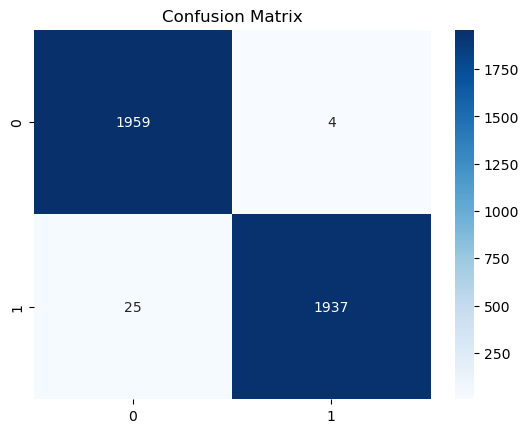

In [27]:
# Plotting Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

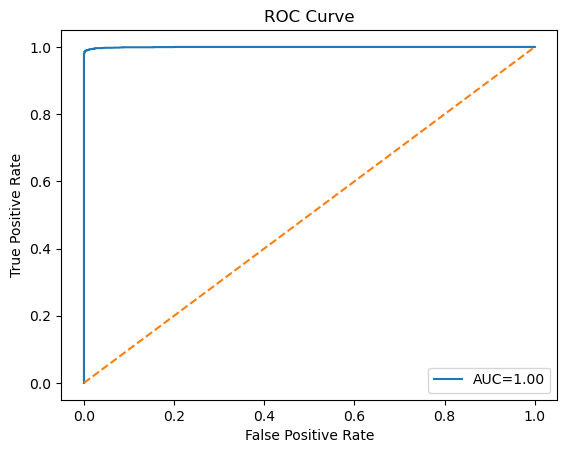

In [28]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

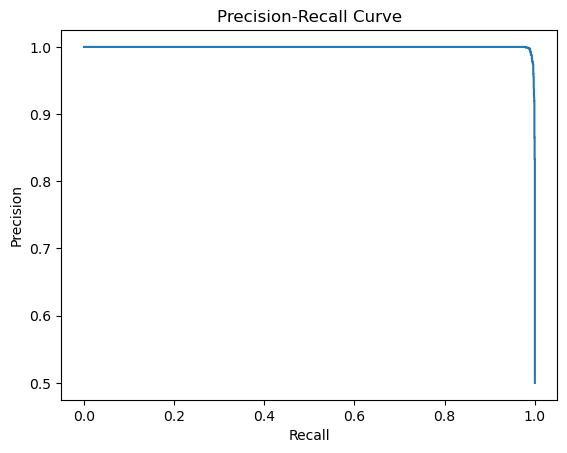

In [29]:
# Precision-Recall Curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

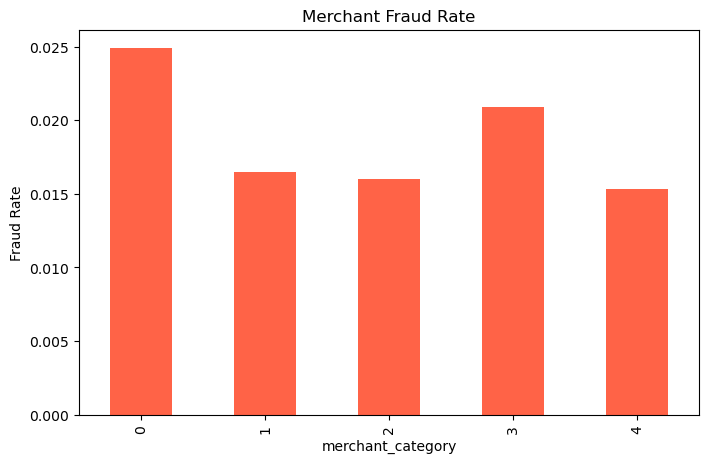

In [30]:
# Plotting Merchant Fraud Rate
merchant_fraud = df.groupby('merchant_category')['is_fraud'].mean()
merchant_fraud.plot(kind='bar', figsize=(8,5), color='tomato')
plt.title("Merchant Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()

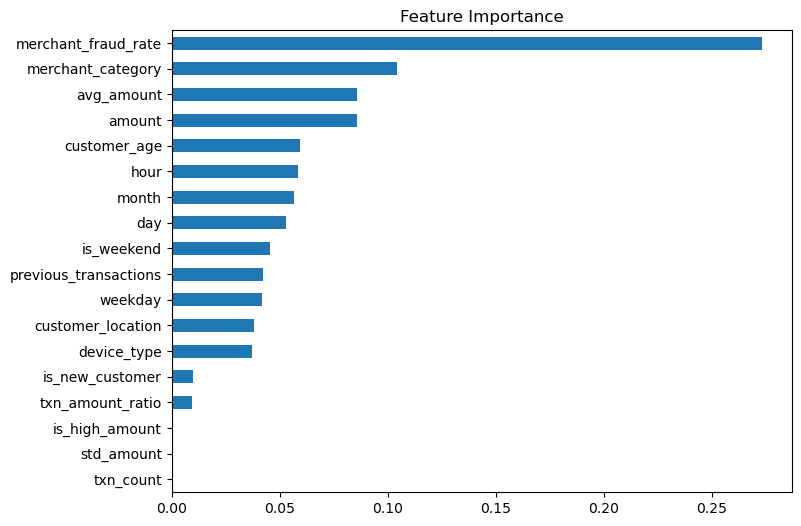

In [31]:
# Plotting feature importance to understand which features impact fraud prediction the most
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance")
plt.show()

In [32]:
# Creating a DataFrame with predicted class labels and their probabilities
# Saving the predictions to a CSV file (fraud_predictions.csv) for submission or further analysis
y_pred_df = pd.DataFrame({"Prediction": y_pred, "Probability": y_prob})
y_pred_df.to_csv("fraud_predictions.csv", index=False)

In [33]:
import joblib

# Saving the trained RandomForest model using joblib for future predictions
joblib.dump(best_model, "fraud_model.pkl")
print("Model saved as fraud_model.pkl")

'''
Insights from the Training Dataset (Points)
Overall Fraud Rate → 1.88% (Dataset is highly imbalanced)

Fraud by Merchant Category
Highest fraud in Electronics (2.49%)
Followed by Fuel (2.09%) and Entertainment (1.64%)

Fraud by Hour
Slightly higher fraud during midnight hours (0–2 AM)

Fraud by Customer History
New customers (0 previous transactions) have a bit higher fraud risk (1.78%)

Fraud by Weekend
Fraud rate is almost the same on weekends and weekdays
'''

Model saved as fraud_model.pkl


In [34]:
# Loading the trained RandomForest model from the saved file
# Using the model to predict fraud labels on the preprocessed test dataset
model = joblib.load("fraud_model.pkl")
#predictions = model.predict(test_df_final)

In [35]:
# Loading the unseen test dataset
test_df = pd.read_csv("sample_test_dataset.csv")

In [36]:
# Applying the same feature engineering steps as training
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['hour'] = test_df['timestamp'].dt.hour
test_df['day'] = test_df['timestamp'].dt.day
test_df['month'] = test_df['timestamp'].dt.month
test_df['weekday'] = test_df['timestamp'].dt.weekday
test_df['is_weekend'] = test_df['weekday'].isin([5, 6]).astype(int)

In [37]:
# Ensuring feature columns match training columns
customer_stats_test = test_df.groupby('customer_id')['amount'].agg(['mean','std','count']).reset_index()
customer_stats_test.rename(columns={'mean':'avg_amount','std':'std_amount','count':'txn_count'}, inplace=True)
test_df = test_df.merge(customer_stats_test, on='customer_id', how='left')

In [38]:
# Merchant fraud rate (from training data)
test_df['merchant_fraud_rate'] = test_df['merchant_category'].map(merchant_fraud)

In [39]:
# Creating derived behavioral features for the test dataset:
#    - txn_amount_ratio: ratio of transaction amount to customer's average amount
#    - is_high_amount: flagging unusually high-value transactions
#    - is_new_customer: flagging customers with no previous transactions
test_df['txn_amount_ratio'] = test_df['amount'] / (test_df['avg_amount'] + 1e-5)
test_df['is_high_amount'] = (test_df['amount'] > 2 * test_df['avg_amount']).astype(int)
test_df['is_new_customer'] = (test_df['previous_transactions'] == 0).astype(int)

In [40]:
# Drop IDs
test_df_final = test_df.drop(['transaction_id', 'customer_id', 'timestamp'], axis=1)

In [41]:
# Encode categorical columns
for col in ['merchant_category', 'customer_location', 'device_type']:
    test_df_final[col] = test_df_final[col].apply(
        lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1
    )

In [42]:
# Filling any missing values (NaN) in the test dataset with 0 
# to avoid errors during model prediction
test_df_final.fillna(0, inplace=True)

In [43]:
# Ensure test dataset has same columns as training
missing_cols = set(X_train.columns) - set(test_df_final.columns)
for col in missing_cols:
    test_df_final[col] = 0

# Reorder columns
test_df_final = test_df_final[X_train.columns]

predictions = model.predict(test_df_final)

In [44]:
# Loading saved model and predicting fraud on the test datase
model = joblib.load("fraud_model.pkl")
predictions = model.predict(test_df_final)

In [45]:
# Saving final predictions to submission.csv
submission = pd.DataFrame({"Prediction": predictions})
submission.to_csv("submission.csv", index=False)
print("Predictions saved to submission.csv")

Predictions saved to submission.csv
